하루 동안 택시 승차 트래픽은 어떻게 변화할까요?

이 질문에 답하기 위해 K-평균 클러스터링을 사용하여 뉴욕을 위치에 따라 여러 그룹으로 클러스터링하고 각 클러스터로 들어오고 나가는 트래픽을 하루 중 시간에 따른 함수로 분석합니다. 주거 지역은 저녁에 유입되는 트래픽이 더 많은 반면, 상업 지역은 낮에 주로 사람들이 모이고 밤에 유흥이 풍부한 지역은 밤에 더 많은 트래픽을 보일 것으로 예상할 수 있습니다.

이를 통해 하루 중 시간대별로 각 지역의 목적지가 어디인지 파악할 수 있으므로 체류 시간 예측에 유용할 수 있습니다.

In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib.pyplot import *
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib import cm
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from dateutil import parser
import io
import base64
from IPython.display import HTML
from imblearn.under_sampling import RandomUnderSampler
from subprocess import check_output
print(check_output(["ls", "../input/New York City Taxi Trip Duration/"]).decode("utf8"))

# ignore warning
import warnings
warnings.filterwarnings(action='ignore')

sample_submission.zip
test.csv
train.csv



### Read the Data

In [2]:
df = pd.read_csv("../input/New York City Taxi Trip Duration/train.csv")

In [3]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


* id - 각 여행의 고유 식별자
* vendor_id - 트립 기록과 연결된 공급업체를 나타내는 코드입니다.
* pickup_datetime - 미터기가 작동한 날짜 및 시간
* dropoff_datetime - 미터기가 연결 해제된 날짜 및 시간
* passenger_count - 차량에 탑승한 승객 수(드라이버가 입력한 값)
* pickup_longitude - 미터기가 작동된 경도
* pickup_latitude - 미터기가 작동된 위도
* dropoff_longitude - 미터기가 연결 해제된 경도
* dropoff_latitude - 미터기를 분리한 위도
* store_and_fwd_flag - 이 플래그는 차량이 서버에 연결되지 않았기 때문에 차량 메모리에 트립 기록이 저장된 후 공급업체로 전송되었는지 여부를 나타냅니다(Y=저장 및 전달, N=저장 및 전달 트립이 아님).
* trip_duration - 트립 기간(초)

### Remove rides to and from far away areas

In [4]:
xlim = [-74.03, -73.77]
ylim = [40.63, 40.85]
df = df[(df['pickup_longitude'] > xlim[0]) & (df['pickup_longitude'] < xlim[1])]
df = df[(df['dropoff_longitude'] > xlim[0]) & (df['dropoff_longitude'] < xlim[1])]
df = df[(df['pickup_latitude'] > ylim[0]) & (df['pickup_latitude'] < ylim[1])]
df = df[(df['dropoff_latitude'] > ylim[0]) & (df['dropoff_latitude'] < ylim[1])]

### Plot rides

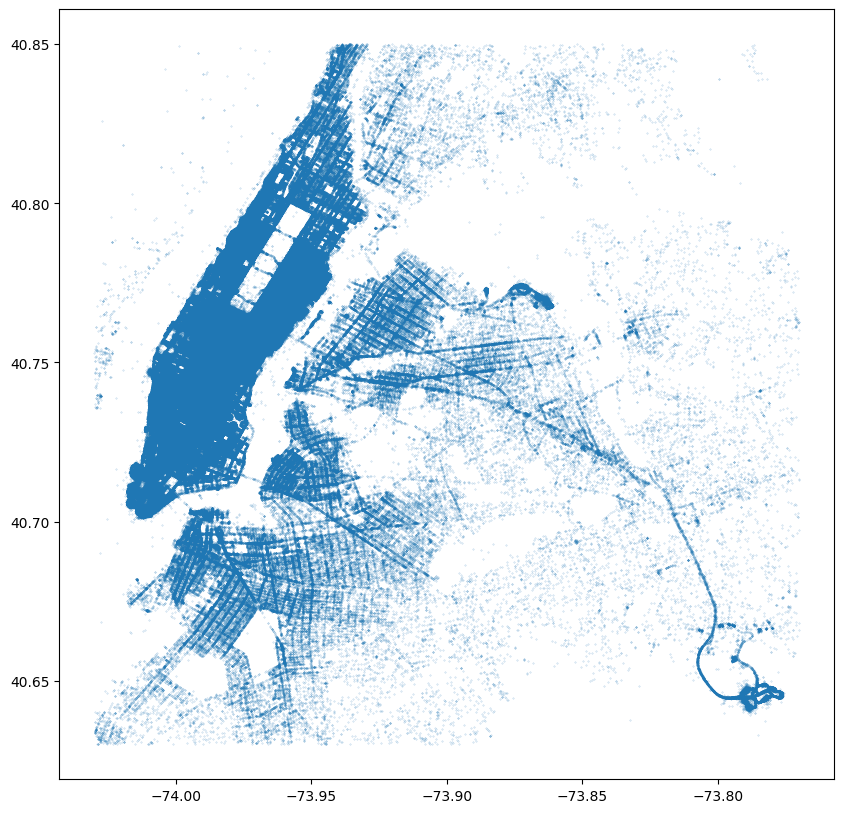

In [5]:
longitude = list(df['pickup_longitude']) + list(df['dropoff_longitude'])
latitude = list(df['pickup_latitude']) + list(df['dropoff_latitude'])
plt.figure(figsize=(10, 10))
plt.plot(longitude, latitude, '.', alpha=0.4, markersize=0.55)
plt.show()

In [6]:
loc_df = pd.DataFrame()
loc_df['longitude'] = longitude
loc_df['latitude'] = latitude

### Cluster

각 택시의 승차 및 하차 지점을 기준으로 뉴욕시를 클러스터링해 보겠습니다.

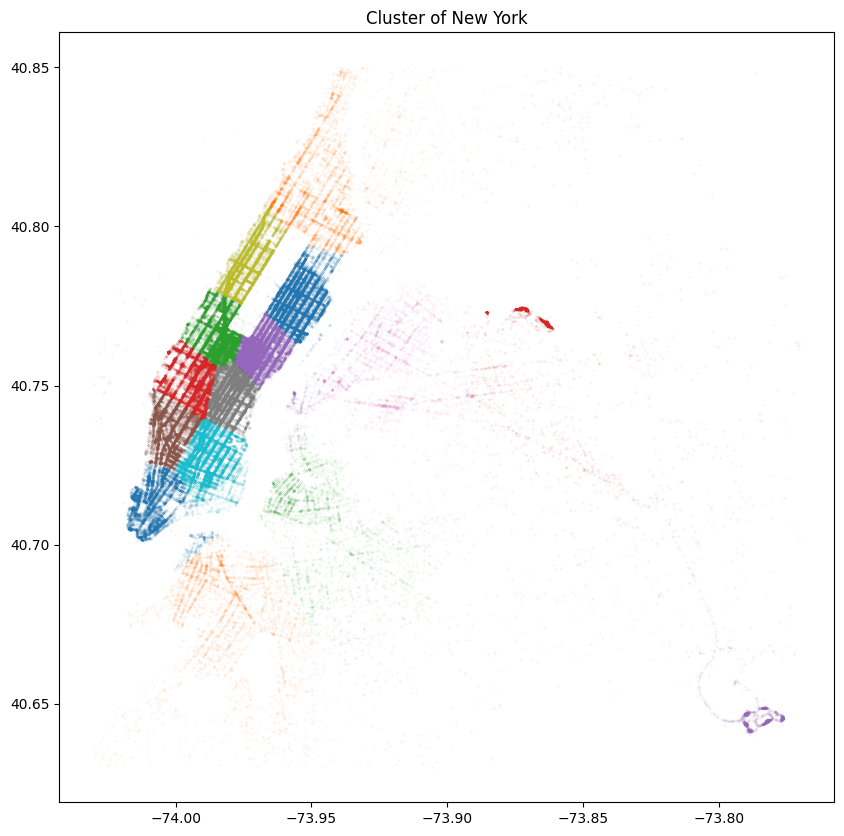

In [7]:
kmeans = KMeans(n_clusters=15, random_state=2, n_init=10).fit(loc_df)
loc_df['label'] = kmeans.labels_

loc_df = loc_df.sample(200000)
plt.figure(figsize=(10, 10))
for label in loc_df.label.unique():
    plt.plot(loc_df.longitude[loc_df.label == label], loc_df.latitude[loc_df.label == label], '.', alpha=0.3, markersize=0.3)
    
plt.title('Cluster of New York')
plt.show()

보시다시피, 클러스터링으로 인해 뉴욕이 여러 지역으로 나뉘는 방식과 다소 유사한 파티션이 생성됩니다. 센트럴 파크의 어퍼 이스트와 웨스트사이드는 각각 회색과 분홍색으로 표시됩니다. 웨스트 미드타운은 파란색, 첼시와 웨스트 빌리지는 갈색, 다운타운 지역은 파란색, 이스트 빌리지와 소호는 보라색으로 표시됩니다.

JFK 공항과 라라과디아 공항에는 자체 클러스터가 있으며 퀸즈와 할렘도 마찬가지입니다. 브루클린은 2개의 클러스터로 나뉘며, 브롱크스는 할렘과 분리하기에는 라이드 수가 너무 적습니다.

클러스터 중심을 그려 보겠습니다:

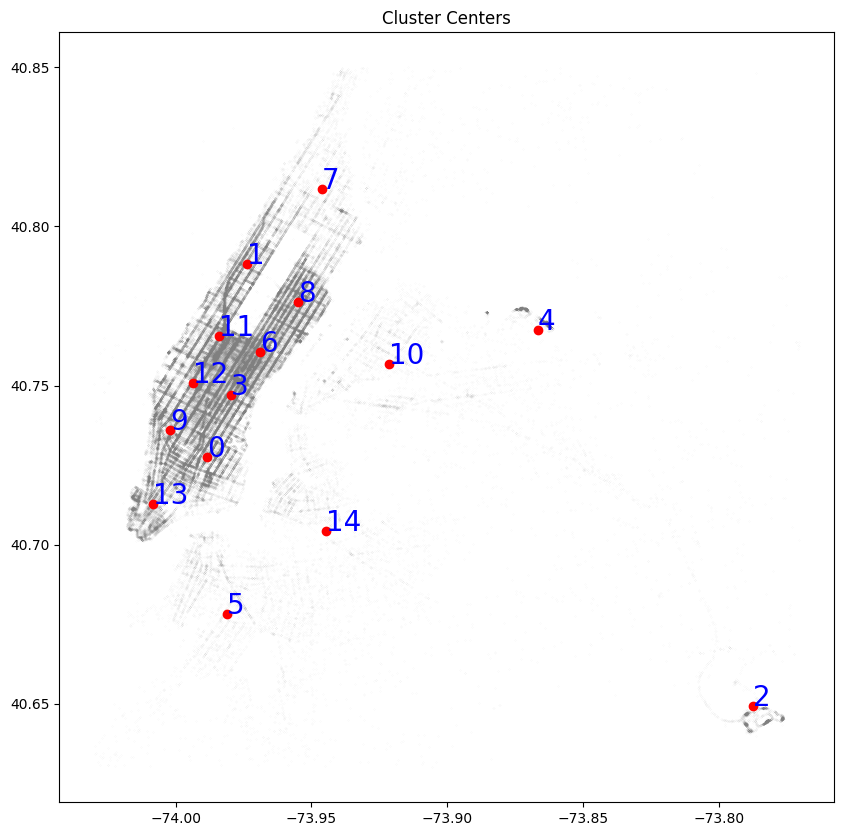

In [8]:
fig, ax = plt.subplots(figsize=(10, 10))
for label in loc_df.label.unique():
    ax.plot(loc_df.longitude[loc_df.label == label], loc_df.latitude[loc_df.label == label], '.', 
            alpha=0.4, markersize=0.1, color='gray')
    ax.plot(kmeans.cluster_centers_[label, 0], kmeans.cluster_centers_[label, 1], 'o', color='r')
    ax.annotate(label, (kmeans.cluster_centers_[label, 0], kmeans.cluster_centers_[label, 1]), color='b', fontsize=20)

ax.set_title('Cluster Centers')
plt.show()    

In [9]:
df['pickup_cluster'] = kmeans.predict(df[['pickup_longitude','pickup_latitude']].rename(columns={'pickup_longitude': 'longitude', 'pickup_latitude': 'latitude'}))
df['dropoff_cluster'] = kmeans.predict(df[['dropoff_longitude','dropoff_latitude']].rename(columns={'dropoff_longitude': 'longitude', 'dropoff_latitude': 'latitude'}))
df['pickup_hour'] = df.pickup_datetime.apply(lambda x: parser.parse(x).hour )

In [10]:
clusters = pd.DataFrame()
clusters['x'] = kmeans.cluster_centers_[:, 0]
clusters['y'] = kmeans.cluster_centers_[:, 1]
clusters['label'] = range(len(clusters))

In [11]:
loc_df = loc_df.sample(5000)

# Taxi rides from one cluster to another

다음 애니메이션에서 모든 화살표는 한 클러스터에서 다른 클러스터로의 이동을 나타냅니다. 화살표의 너비는 해당 시간 동안의 상대적인 운행 횟수에 비례합니다.

MovieWriter imagemagick unavailable; using Pillow instead.



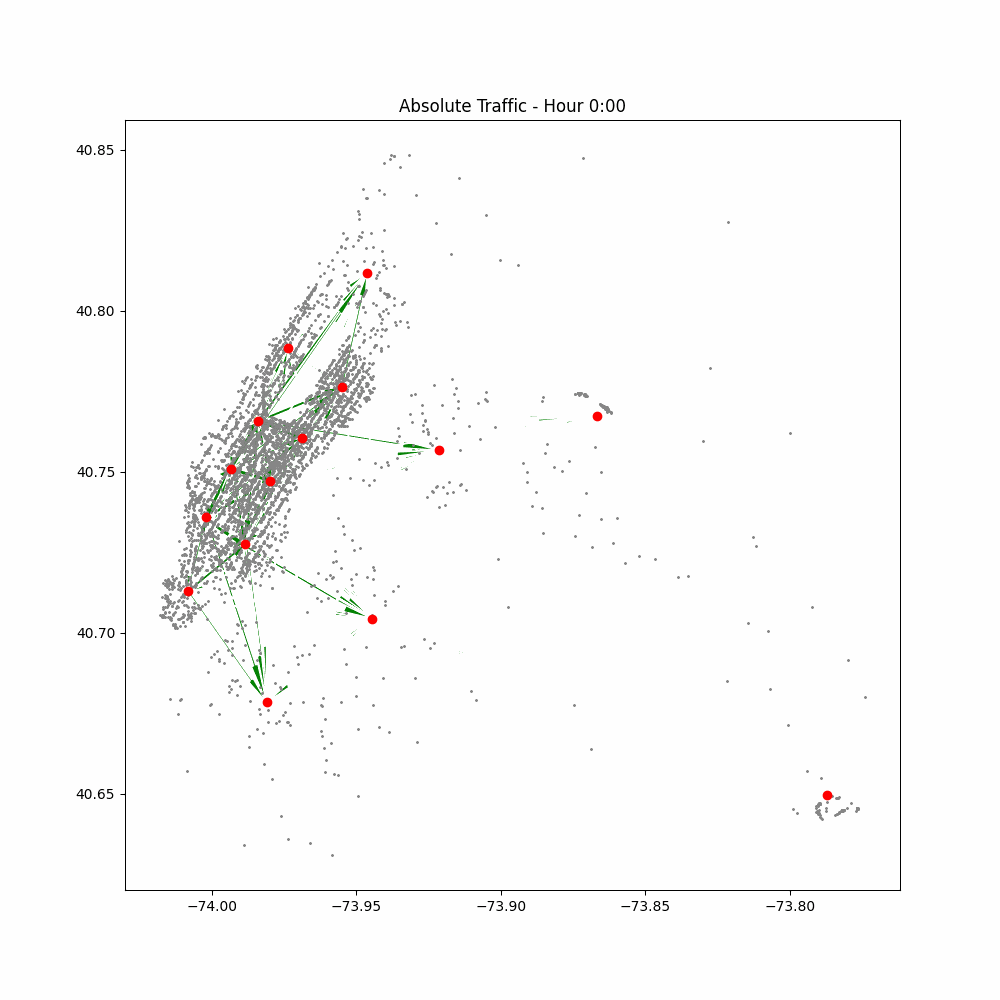

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

def animate(hour):
    ax.clear()
    ax.set_title('Absolute Traffic - Hour ' + str(int(hour)) + ':00')
    plt.figure(figsize=(10, 10))
    
    for label in loc_df.label.unique():
        ax.plot(loc_df.longitude[loc_df.label == label], loc_df.latitude[loc_df.label == label], '.', 
               alpha=1, markersize=2, color='gray')
        ax.plot(kmeans.cluster_centers_[label, 0], kmeans.cluster_centers_[label, 1], 'o', color='r')
        
    for label in clusters.label:
        for dest_label in clusters.label:
            num_of_rides = len(df[(df.pickup_cluster == label) & (df.dropoff_cluster == dest_label) & (df.pickup_hour == hour)])
            dist_x = clusters.x[clusters.label == label].values[0] - clusters.x[clusters.label == dest_label].values[0]
            dist_y = clusters.y[clusters.label == label].values[0] - clusters.y[clusters.label == dest_label].values[0]
            pct = np.true_divide(num_of_rides, len(df))
            arr = Arrow(clusters.x[clusters.label == label].values, clusters.y[clusters.label == label].values, -dist_x, -dist_y, edgecolor='white', width=15*pct)
            ax.add_patch(arr)
            arr.set_facecolor('g')
            
ani = animation.FuncAnimation(fig, animate, sorted(df.pickup_hour.unique()), interval=1000)
plt.close()
ani.save('animation.gif', writer='imagemagick', fps=2)
filename='animation.gif'
video = io.open(filename, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<img src="data:image/gif;base64,{0}" type="gif" />'''.format(encoded.decode('ascii')))

아침에는 대부분의 교통량이 맨해튼 섬에 집중되어 있음을 알 수 있습니다.

윌리엄스버그를 중심으로 브루클린 지역으로 이동하는 택시의 비중은 늦은 저녁에 훨씬 더 커집니다. 아침 시간대에는 (반대 방향으로) 비슷한 움직임이 없기 때문에 출퇴근의 결과일 가능성은 낮습니다. 대신 22시 이후에는 주로 교통량이 많으므로 외출하는 사람들일 가능성이 높습니다.

화살표는 해당 시간대의 상대적인 교통량을 나타내므로 브루클린으로 향하는 화살표의 폭이 커지는 것은 맨해튼의 상업적 특성으로 인해 맨해튼의 차량 운행이 감소한 결과일 수도 있습니다. 하지만 절대적인 교통량을 보면 맨해튼에서 브루클린으로 향하는 화살표는 하루 중 대부분의 시간 동안 거의 보이지 않습니다.

이른 아침에는 대부분의 교통량이 두 공항을 오가는 교통량입니다. 절대 그래프에서 알 수 있듯이 이는 다른 지역의 트래픽이 감소한 결과일 뿐입니다.

# Neighborhood Analysis

각 클러스터에 동내 이름을 수동으로 할당한다.

In [13]:
neighborhood = {-74.0019368351: 'Chelsea',
                -73.837549761: 'Queens',
                -73.7854240738: 'JFK',
                -73.9810421975:'Midtown-North-West',
                -73.9862336241: 'East Village',
                -73.971273324:'Midtown-North-East',
                -73.9866739677: 'Brooklyn-parkslope',
                -73.8690098118: 'LaGuardia',
                -73.9890572967:'Midtown',
                -74.0081765545: 'Downtown',
                -73.9213024854: 'Queens-Astoria',
                -73.9470256923: 'Harlem',
                -73.9555565018: 'Uppe East Side',
                -73.9453487097: 'Brooklyn-Williamsburgt',
                -73.9745967889:'Upper West Side'}

In [14]:
rides_df = pd.DataFrame(columns=neighborhood.values())
rides_df['name'] = neighborhood.values()

neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(np.array(list(neighborhood.keys())).reshape(-1, 1), list(neighborhood.values()))

KNeighborsClassifier(n_neighbors=1)

In [15]:
df['pickup_neighborhood'] = neigh.predict(df.pickup_longitude.values.reshape(-1, 1))
df['dropoff_neighborhood'] = neigh.predict(df.dropoff_longitude.values.reshape(-1, 1))

for col in rides_df.columns[:-1]:
    rides_df[col] = rides_df.name.apply(lambda x: len(df[(df.pickup_neighborhood == x) & (df.dropoff_neighborhood == col)]))

이제 히트맵을 그려서 승객이 어디로 이동하고 어디에서 출발하는지 살펴봅시다(모든 라이드의 총합 값입니다):

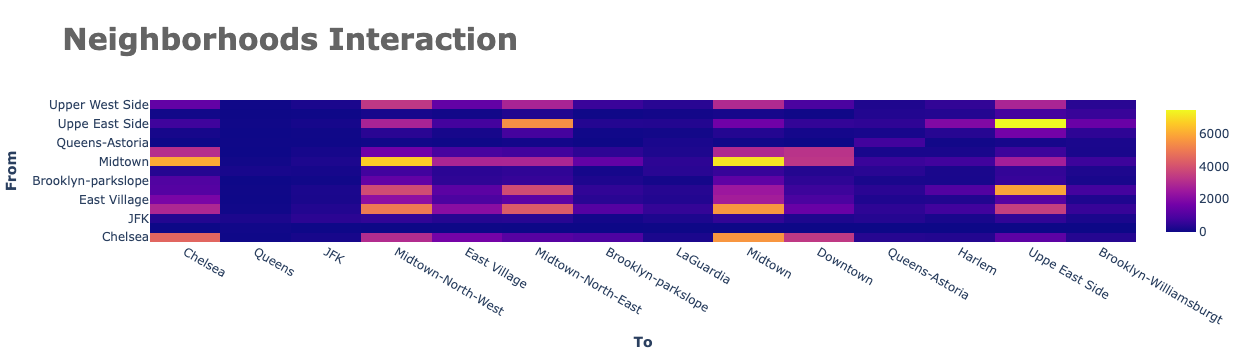

In [26]:
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

trace = go.Heatmap(z= np.array(rides_df.values),
                  x = rides_df.columns[:-1],
                  y = rides_df.columns)
layout = dict(
    title = ' <b>Neighborhoods Interaction</b>',
    titlefont = dict(
    size = 30,
    color = ('rgb(100,100,100)')),
    margin = dict(t=100,r=100,b=100,l=150),
        yaxis = dict(
            title = ' <b> From </b>'),
        xaxis = dict(
            title = '<b> To </b>'))
data=[trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='labelled-heatmap')

Text(0.5, 1.35, 'Neighborhoods Interaction')

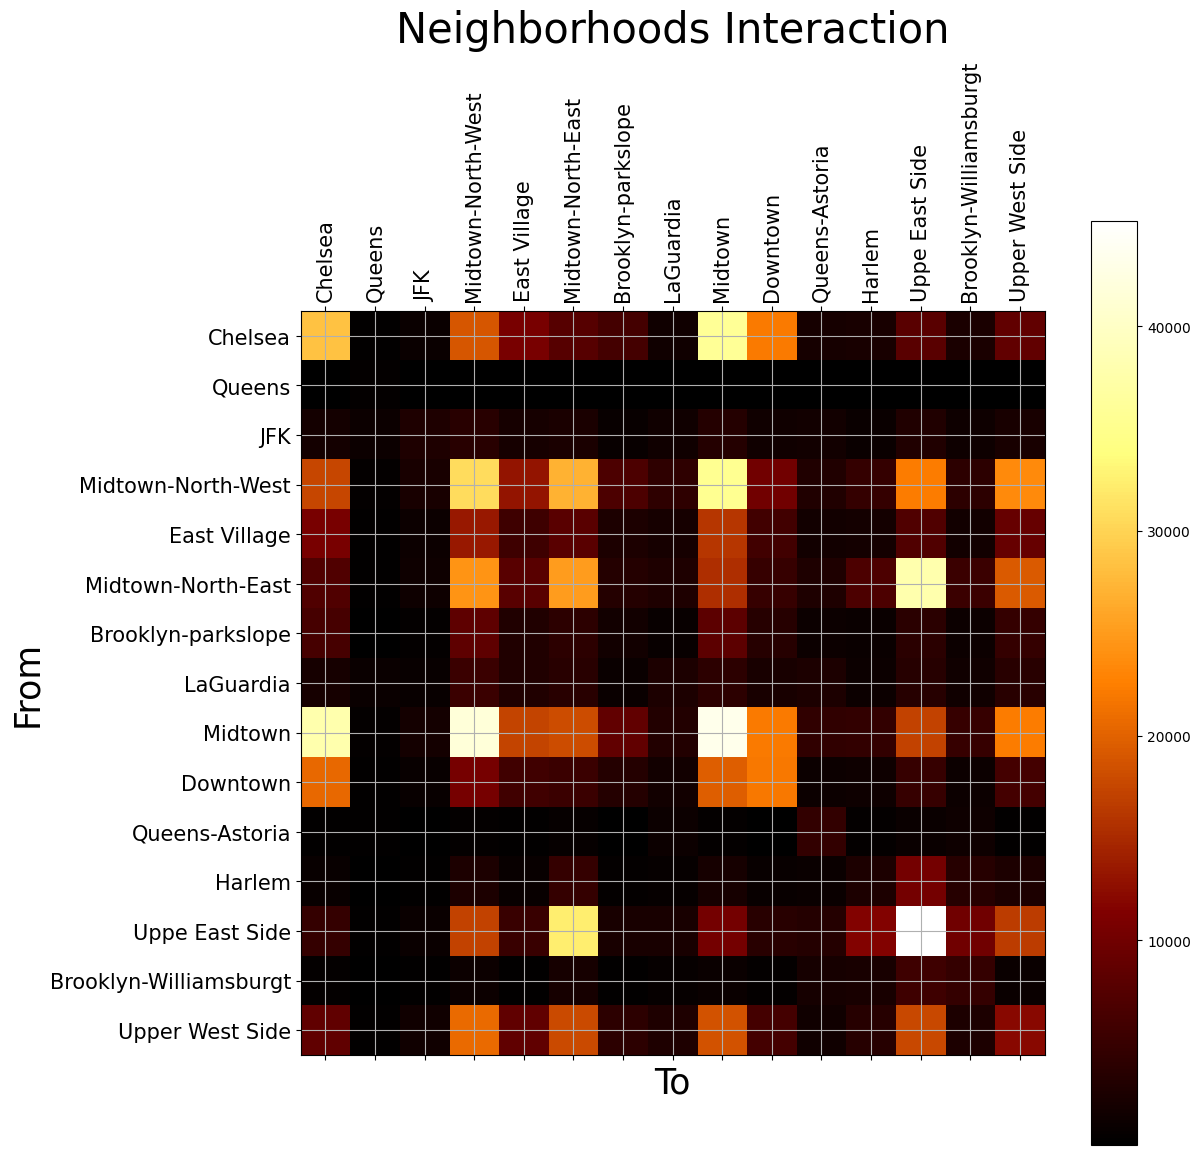

In [17]:
fig,ax = plt.subplots(figsize = (12,12))
cax = ax.matshow(rides_df.drop('name',axis = 1),interpolation='nearest',cmap=cm.afmhot)
cbar = fig.colorbar(cax)
ax.grid('off')
ax.set_xticks(range(len(rides_df)))
ax.set_xticklabels(rides_df.name, rotation =90,fontsize = 15)
ax.set_yticks(range(len(rides_df)))
ax.set_yticklabels(rides_df.name,fontsize = 15)
ax.set_xlabel('To', fontsize = 25)
ax.set_ylabel('From', fontsize = 25)
ax.set_title('Neighborhoods Interaction', y=1.35, fontsize = 30)

In [18]:
rides_df.index = rides_df.name
rides_df = rides_df.drop('name', axis = 1)

맨해튼 중심부 지역이 가장 택시가 붐비는 지역이며, 어퍼 이스트사이드가 선두를 달리고 있음을 알 수 있습니다. 또한 애니메이션에서는 볼 수 없는 클러스터 내에서 가장 많이 승차하는 것을 알 수 있습니다.

히트맵은 상당히 대칭을 이루며, 이는 픽업이 하차보다 월등히 많은 클러스터가 없거나 그 반대의 경우도 마찬가지라는 것을 의미합니다. 확대해 보겠습니다:

Text(0.5, 1.0, 'Inbound and Outbound rides for each cluster')

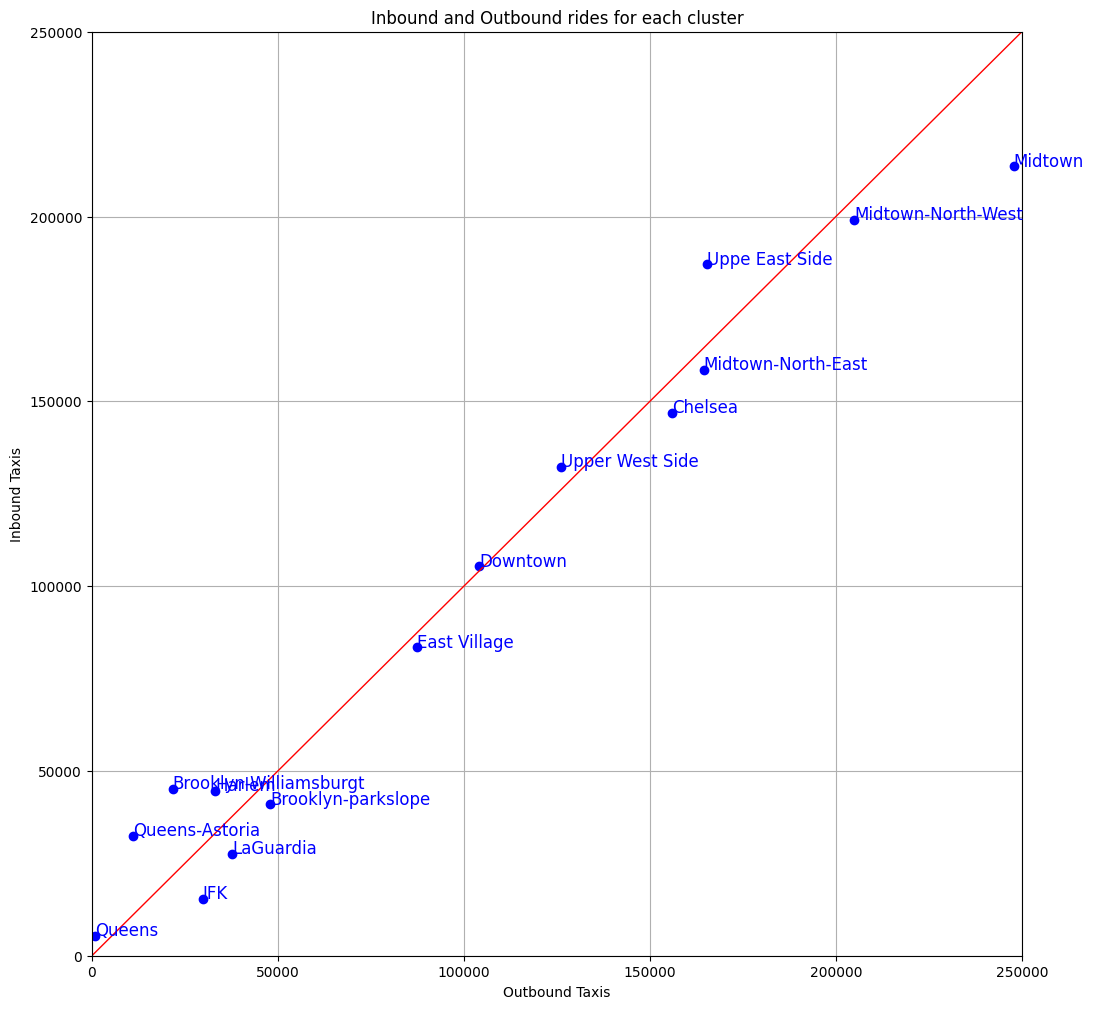

In [19]:
fig, ax = plt.subplots(figsize = (12, 12))
for i in range(len(rides_df)):
    ax.plot(rides_df.sum(axis = 1)[i], rides_df.sum(axis = 0)[i], 'o', color = 'b')
    ax.annotate(rides_df.index.tolist()[i], (rides_df.sum(axis = 1)[i], rides_df.sum(axis = 0)[i]), color = 'b', fontsize = 12)
    
ax.plot([0, 250000], [0, 250000], color = 'r', linewidth = 1)
ax.grid('off')
ax.set_xlim([0, 250000])
ax.set_ylim([0, 250000])
ax.set_xlabel('Outbound Taxis')
ax.set_ylabel('Inbound Taxis')
ax.set_title('Inbound and Outbound rides for each cluster')

각 지역의 인바운드와 아웃바운드 비율이 비교적 균형을 이루고 있음을 알 수 있습니다.

두 공항은 인바운드보다 아웃바운드가 더 많은데, 이는 드라이버들이 승객이 없어도 사람들을 시내로 데려갈 기회를 얻기 위해 공항으로 가는 것이기 때문에 당연한 결과입니다. 주거 지역인 쿠엔즈, 브루클린, 할렘은 인바운드가 더 많은 반면, 상업 및 관광 지역일수록 아웃바운드가 더 많습니다. 어퍼 이스트와 웨스트는 상업 및 주거 지역으로 거의 곡선을 이루고 있습니다.

사람들은 다른 교통수단을 이용해 맨해튼으로 들어오는 경우가 많지만, 맨해튼을 빠져나갈 때는 택시를 이용하는 경우가 더 많은 것으로 보입니다.

# Winter vs Summer

In [20]:
df['pickup_month'] = df.pickup_datetime.apply(lambda x: parser.parse(x).month)

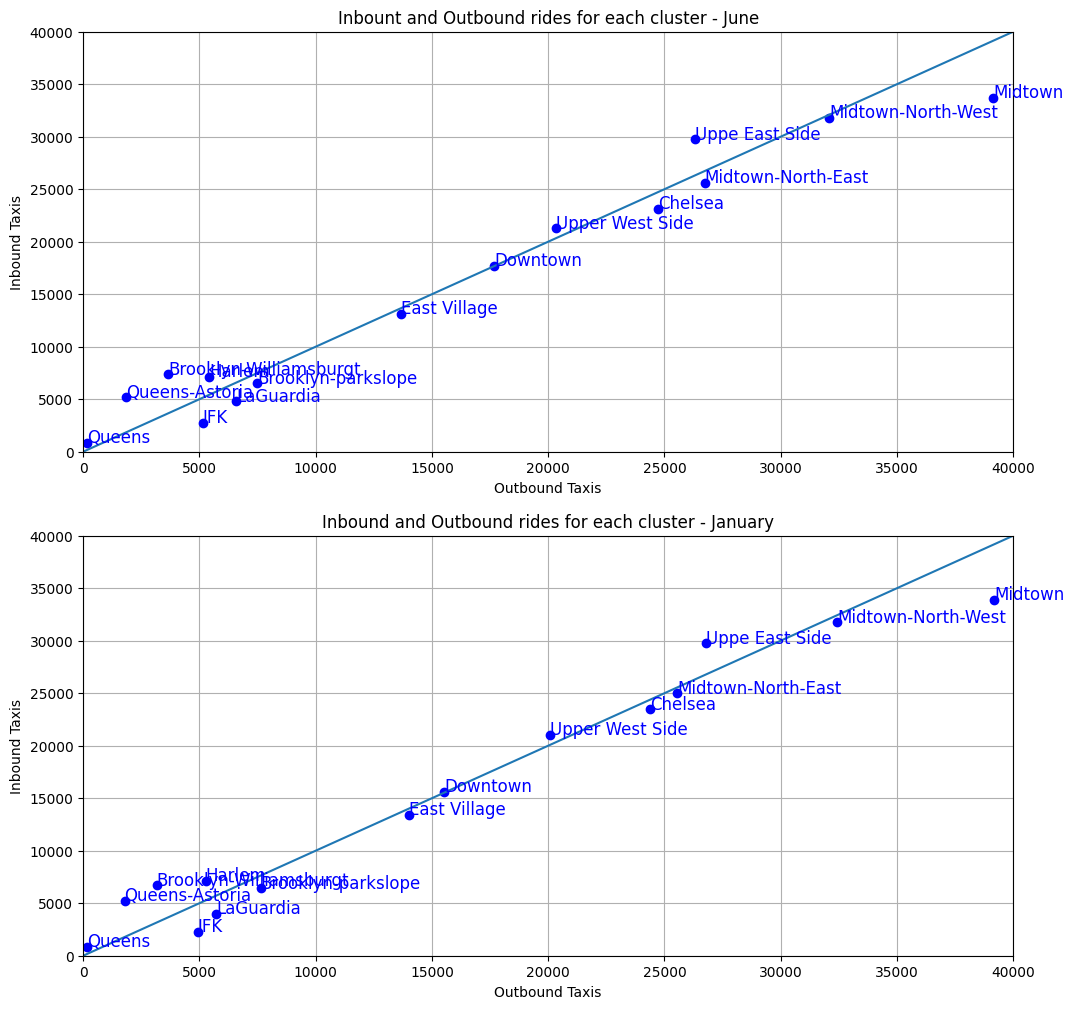

In [21]:
fig, ax = plt.subplots(2, figsize = (12, 12))

rides_df = pd.DataFrame(columns = neighborhood.values())
rides_df['name'] = neighborhood.values()
rides_df.index = rides_df.name

for col in rides_df.columns[:-1]:
    rides_df[col] = rides_df.name.apply(lambda x: len(df[(df.pickup_neighborhood == x) & (df.dropoff_neighborhood == col) & (df.pickup_month == 6)]))
    
for i in range(len(rides_df)):
    ax[0].plot(rides_df.sum(axis = 1)[i], rides_df.sum(axis = 0)[i], 'o', color = 'b')
    ax[0].annotate(rides_df.index.tolist()[i], (rides_df.sum(axis = 1)[i], rides_df.sum(axis = 0)[i]), color = 'b', fontsize = 12)
    
ax[0].grid('off')
ax[0].set_xlabel('Outbound Taxis')
ax[0].set_ylabel('Inbound Taxis')
ax[0].set_title('Inbount and Outbound rides for each cluster - June')
ax[0].set_xlim([0, 40000])
ax[0].set_ylim([0, 40000])
ax[0].plot([0, 40000], [0, 40000])

for col in rides_df.columns[:-1]:
    rides_df[col] = rides_df.name.apply(lambda x: len(df[(df.pickup_neighborhood == x) & (df.dropoff_neighborhood == col) & (df.pickup_month == 1)])) 

rides_df = rides_df.drop('name', axis = 1)

for i in range(len(rides_df)):  
    ax[1].plot(rides_df.sum(axis = 1)[i],rides_df.sum(axis = 0)[i],'o', color = 'b')
    ax[1].annotate(rides_df.index.tolist()[i], (rides_df.sum(axis = 1)[i],rides_df.sum(axis = 0)[i]), color = 'b', fontsize = 12)

ax[1].grid('off')
ax[1].set_xlabel('Outbound Taxis')
ax[1].set_ylabel('Inbound Taxis')
ax[1].set_title('Inbound and Outbound rides for each cluster - January')
ax[1].set_xlim([0,40000])
ax[1].set_ylim([0,40000])
ax[1].plot([0,40000],[0,40000])


보시다시피 패턴은 월에 관계없이 거의 동일합니다. 눈이 내리는 1월과 습하고 관광이 많은 6월의 택시 패턴은 매우 유사합니다.